In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

## First let's try to detect the helical trajectory (for the x-y plane) in a single-particle file

In [4]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n1-1GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file)) for file in hit_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]
dfs[0]

,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index
0,4503599644147712,936748859932016666,30.413637,11.115355,5.232724,0.110008,0.935862,0.352368,0.161595,1.018468,0,0,0,0,0
1,4503599644147712,936748997370970292,64.061615,24.201923,11.066949,0.232662,0.928015,0.372542,0.161595,1.018468,0,0,0,0,1
2,4503599644147712,936749134809923918,106.106827,41.751125,18.429562,0.387448,0.917493,0.397752,0.161595,1.018468,0,0,0,0,2
3,4503599644147712,936749272248877698,157.508713,65.075996,27.551474,0.579219,0.903508,0.428572,0.161595,1.018468,0,0,0,0,3
4,4503599644147712,1297036830121656806,236.034622,104.896332,41.780827,0.878365,0.879632,0.475655,0.161595,1.018468,0,0,0,0,4
5,4503599644147712,1297036967560610509,324.346497,156.205612,58.287987,1.225398,0.848868,0.528605,0.161595,1.018468,0,0,0,0,5
6,4503599644147712,1297037104999564444,441.400421,236.195892,81.205002,1.707186,0.800907,0.598789,0.161595,1.018468,0,0,0,0,6
7,4503599644147712,1297037242438518651,565.066467,338.278687,107.127823,2.252166,0.739699,0.672937,0.161595,1.018468,0,0,0,0,7
8,4503599644147712,1657324800311298359,676.431946,449.645935,132.587845,2.787417,0.672925,0.739710,0.161595,1.018468,0,0,0,0,8
9,4503599644147712,1657324800311298360,681.167236,454.873383,133.727631,2.811379,0.669791,0.742550,0.161595,1.018468,0,0,0,0,9


In [5]:
random.seed(8)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['track'] = df[['tx','ty']].apply(lambda xy_pair: (-xy_pair[0] / xy_pair[1],
                                                     (xy_pair[0] ** 2 + xy_pair[1] ** 2) / (2 * xy_pair[1])), 1)

Event chosen: event000000029-hits.csv


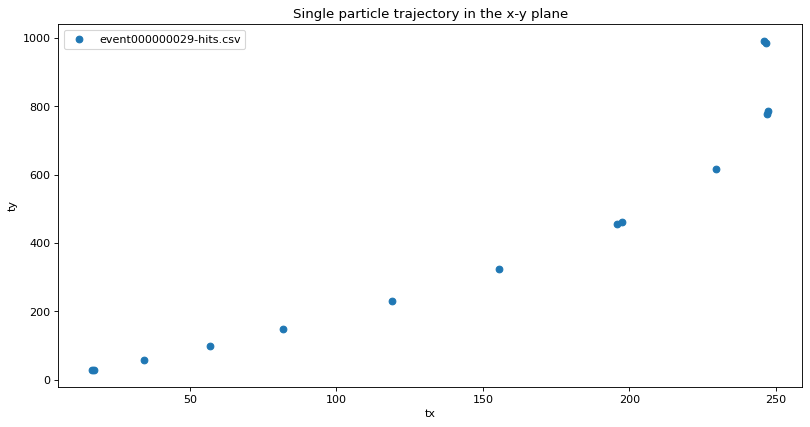

In [6]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

In the x-y plane, the helix becomes a circle (since the magnetic field is constant in the z axis). The equation of a circle $C$ with center $(x_0, y_0)$ and radius $r$ is

$$(x - x_0)^2 + (y - y_0)^2 = r^2$$

After confirming with Noemi, for this experiment we can make the safe assumption that the circle must go through the origin $(0, 0)$. Generally, this will not always hold (even though the track may come close to the origin).

Substituting $x = y = 0$ in the circle equation yields:

$$r^2 = x_0^2 + y_0^2$$

Using this (again) in the circle equation gives us:

$$(x - x_0)^2 + (y - y_0)^2 = x_0^2 + y_0^2 \;\Leftrightarrow\; x^2 + y^2 = 2 (x_0x + y_0y)$$

We managed to convert an equation with 3 unknown variables to one with 2 unknowns. Furthermore, if we solve for $y_0$, we notice that it can be expressed as a linear function of $x_0$:

$$y_0 = -\frac{x}{y}x_0 + \frac{x^2 + y^2}{2y}$$

This suggests that the parameters $x_0, y_0$ can be linked by a straight line in the Hough space, as we have already done in the previous notebook. Hence, we can again use binning methods to find their values.

In [7]:
tracks_in_hough_space = list(df['track'])
tracks_in_hough_space

[(-0.6060752087467878, 18.819705738931315),
 (-0.6056714281779781, 19.39224442778191),
 (-0.5915529731138423, 39.410811432858594),
 (-0.5727075138160743, 66.13176474650807),
 (-0.5509790353614057, 96.9405175458251),
 (-0.5162479427782852, 146.18571440001034),
 (-0.47855918945562087, 199.62456081611646),
 (-0.42635265689582275, 273.6481627777527),
 (-0.4285714620153365, 270.50210334693907),
 (-0.37165703789476856, 351.20100374924675),
 (-0.3169131079031302, 428.8223536268362),
 (-0.31454007081210555, 432.1870877713461),
 (-0.2503023901219901, 523.269625932933),
 (-0.24796302181027377, 526.5866185499553)]

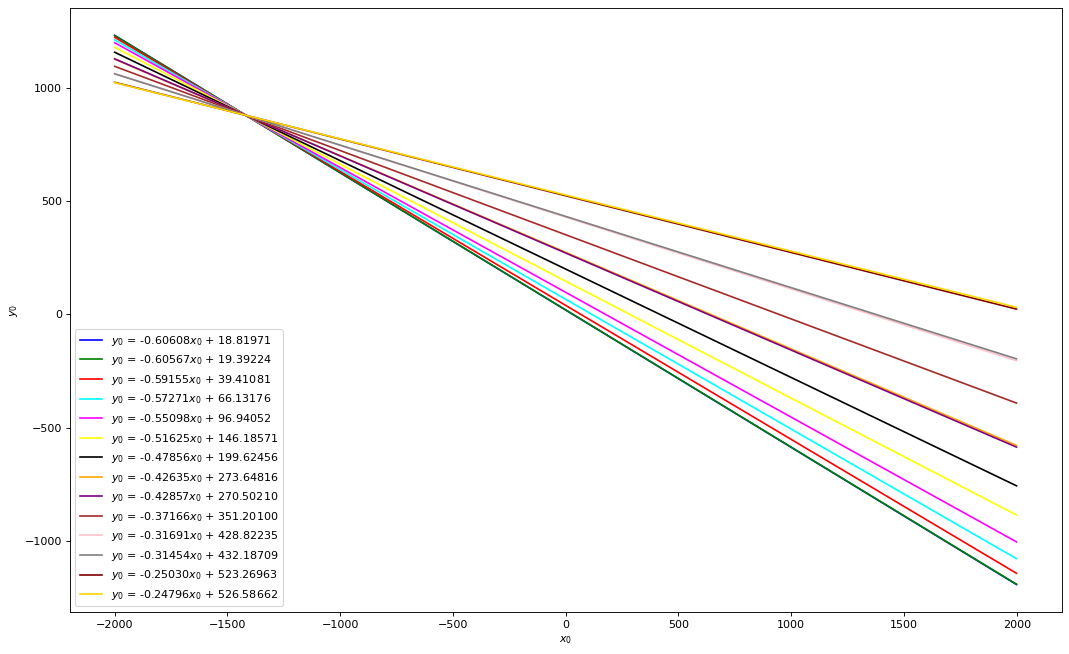

In [8]:
x_range = np.arange(-2000, 2000)

plt.figure(figsize=(16, 10), dpi=80)
for idx, line in enumerate(tracks_in_hough_space):
    m, b = line
    plt.plot(x_range, m * x_range + b, color=colors[idx % len(colors)],
             label=f"$y_0$ = -{-m:.5f}$x_0$ {('+' if b > 0 else '')} {b:.5f}")
    
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.legend(loc='best')
plt.show()

Get all the intersection points, so that we can start searching in this range.

In [9]:
from notebook2_utils import compute_all_intersections, get_limits

intersections = compute_all_intersections(tracks_in_hough_space)
x_limits, y_limits = get_limits(list(intersections.values()))
x_limits, y_limits

((-1417.9451243492824, -1417.897385847438),
 (878.1722514415054, 878.2010929704127))

Run through the pipeline.

In [10]:
from notebook2_utils import pipeline

bin_size = (0.001, 0.001)
limits = (x_limits, y_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

est_tracks_to_hits = pipeline(tracks_in_hough_space, intersections, bin_size, limits, selection_hyperparams)
est_tracks_to_hits

{(-1417.8991243492824,
  878.1722514415054): [(-0.5509790353614057,
   96.9405175458251), (-0.4285714620153365, 270.50210334693907), (-0.24796302181027377,
   526.5866185499553), (-0.6056714281779781,
   19.39224442778191), (-0.6060752087467878, 18.819705738931315), (-0.5162479427782852,
   146.18571440001034), (-0.3169131079031302,
   428.8223536268362), (-0.47855918945562087, 199.62456081611646), (-0.42635265689582275,
   273.6481627777527), (-0.2503023901219901,
   523.269625932933), (-0.31454007081210555, 432.1870877713461), (-0.5915529731138423,
   39.410811432858594), (-0.37165703789476856,
   351.20100374924675), (-0.5727075138160743, 66.13176474650807)]}

We observe that only 1 configuration of $x_0, y_0$ parameters had at least 10 hits inside the bin. Probably this is the best solution. We can now infer the radius from it using the formula $r = \sqrt{x_0^2 + y_0^2}$. Let's plot it out to see:

In [11]:
x_0, y_0 = list(est_tracks_to_hits.keys())[0]
r = np.sqrt(np.square(x_0) + np.square(y_0))
x_0, y_0, r

(-1417.8991243492824, 878.1722514415054, 1667.8202631076)

In [12]:
circle_points = []
for x in np.arange(x_0 - r, x_0 + r, 0.1):
    y1 = y_0 + np.sqrt(r ** 2 - (x - x_0) ** 2)
    y2 = y_0 - np.sqrt(r ** 2 - (x - x_0) ** 2)
    circle_points.append((x, y1))
    circle_points.append((x, y2))
    
circle_xs = [point[0] for point in circle_points]
circle_ys = [point[1] for point in circle_points]

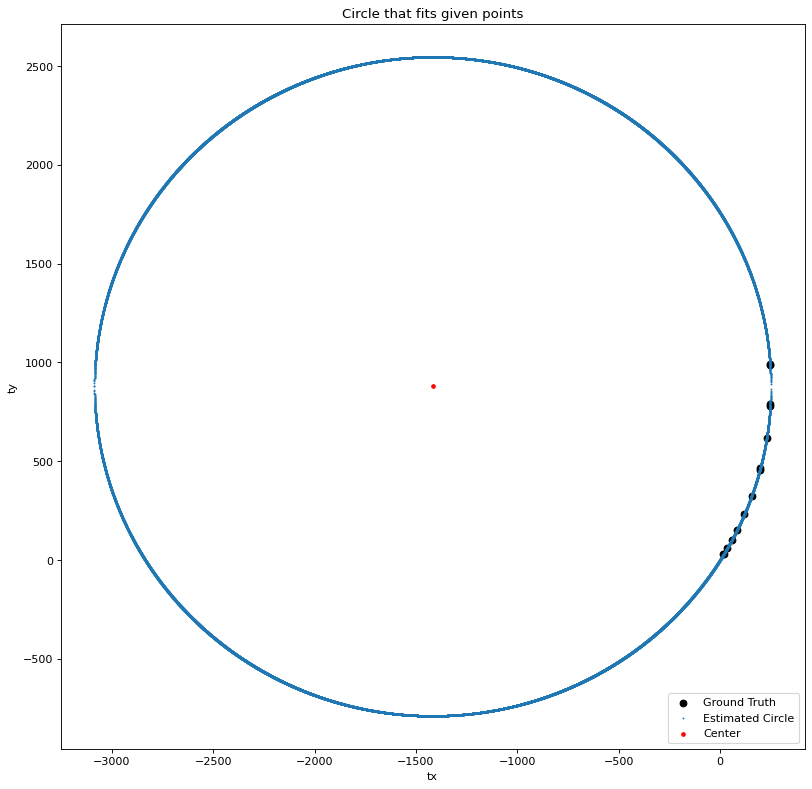

In [13]:
plt.figure(figsize=(12, 12), dpi=80)

plt.scatter(x=df['tx'], y=df['ty'], label='Ground Truth', color='k')
plt.scatter(x=circle_xs, y=circle_ys, label='Estimated Circle', s=0.5)
plt.scatter(x=[x_0], y=[y_0], label='Center', color='r', s=10)
plt.legend(loc='lower right')
plt.xlabel('tx')
plt.ylabel('ty')
plt.title('Circle that fits given points')

plt.show()

For a sanity check, let's compute the emittance angle via the momentum (ground truth) and the estimation for it using a tangent line to the circle at the origin.

In [14]:
tangent_point = (0, 0)
x_1, y_1 = tangent_point
tangent_m = -(x_1 - x_0) / (y_1 - y_0)
tangent_b = x_1 * (x_1 - x_0) / (y_1 - y_0) + y_1
tangent_m, tangent_b

(1.6146025133700412, 0.0)

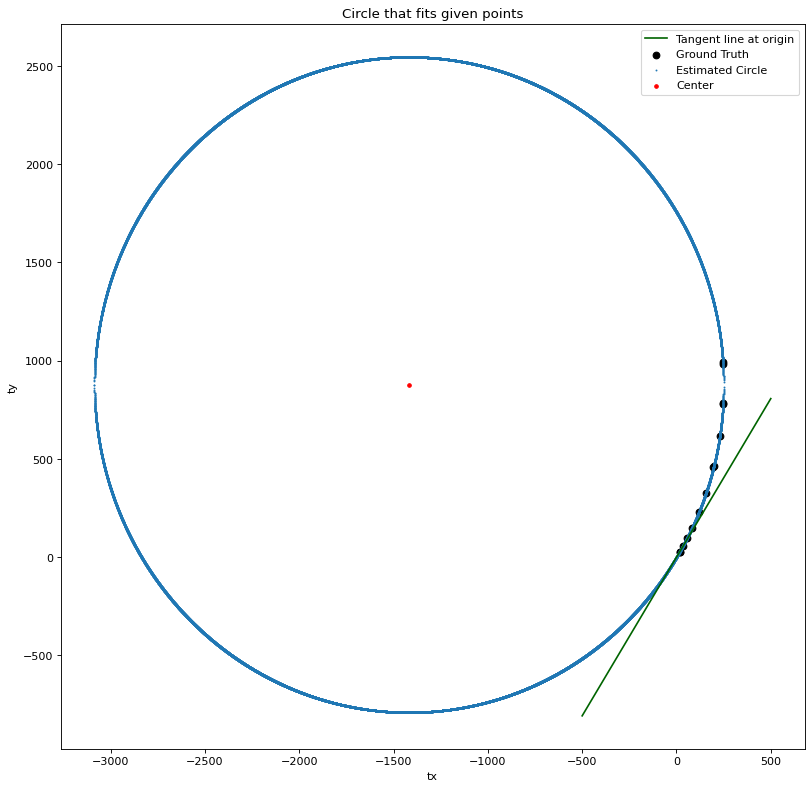

In [15]:
xs = np.arange(-500, 500, 0.1)
ys = tangent_m * xs + tangent_b

plt.figure(figsize=(12, 12), dpi=80)

plt.scatter(x=df['tx'], y=df['ty'], label='Ground Truth', color='k')
plt.scatter(x=circle_xs, y=circle_ys, label='Estimated Circle', s=0.5)
plt.scatter(x=[x_0], y=[y_0], label='Center', color='r', s=10)
plt.plot(xs, ys, label='Tangent line at origin', color='darkgreen')
plt.legend(loc='best')
plt.xlabel('tx')
plt.ylabel('ty')
plt.title('Circle that fits given points')

plt.show()

In [16]:
xa, xb = 0, 1
ya, yb = tangent_m * xa + tangent_b, tangent_m * xb + tangent_b

phi_est = np.arctan2((yb - ya), (xb - xa))
phi_truth = np.arctan2(final_df['py'], final_df['px'])
print(f'phi_truth: {phi_truth.item()}, phi_est: {phi_est}')

phi_truth: 1.67913727727374, phi_est: 1.016272074004941


Not getting the same answer, might want to look into it.

## Let's try it now for many-particle files

In [ ]:
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])

dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
       for file in hit_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

dfs[0]

In [ ]:
random.seed(4)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
df['weight'] = 1.0
df['track'] = df[['tx','ty']].apply(lambda xy_pair: (-xy_pair[0] / xy_pair[1],
                                                     (xy_pair[0] ** 2 + xy_pair[1] ** 2) / (2 * xy_pair[1])), 1)

In [ ]:
# get every particle
unique_particle_ids = list(set(df['particle_id']))
plt.figure(figsize=(12, 7), dpi=80)

# plot its track
for idx, pid in enumerate(unique_particle_ids):
    particle_df = df[df['particle_id'] == pid]
    plt.scatter(x=particle_df['tx'], y=particle_df['ty'], color=colors[idx])

plt.xlabel('tx')
plt.ylabel('ty')
plt.title('Particle trajectories in the x-y plane')
plt.show()

In [ ]:
all_tracks = list(df['track'])

In [ ]:
x_range = np.arange(-20000, 20000)

plt.figure(figsize=(16, 10), dpi=80)
for idx, line in enumerate(all_tracks):
    m, b = line
    plt.plot(x_range, m * x_range + b, color=colors[idx % len(colors)])
    
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.show()

In [ ]:
from notebook2_utils import compute_all_intersections, get_limits

intersections = compute_all_intersections(all_tracks)
x_limits, y_limits = get_limits(list(intersections.values()))
x_limits, y_limits

Run the intersections through the pipeline.

In [ ]:
from notebook2_utils import pipeline

bin_size = (0.1, 0.1)
limits = (x_limits, y_limits)
selection_hyperparams = {'minimum-hits-per-bin': 11}

est_tracks_to_hits = pipeline(all_tracks, intersections, bin_size, limits, selection_hyperparams)
len(est_tracks_to_hits)

Compute the radius for each track.

In [ ]:
est_track_to_est_radius = {(x_0, y_0): np.sqrt(np.square(x_0) + np.square(y_0)) for x_0, y_0 in est_tracks_to_hits}
est_track_to_est_radius

Let's plot all the circles we found.

In [ ]:
plt.figure(figsize=(12, 12), dpi=80)

cnt = 0
start_time = time.time()
for track, r in est_track_to_est_radius.items():
    print(f'Starting to plot track {cnt}')
    x_0, y_0 = track
    circle_points = []
    for x in np.arange(x_0 - r, x_0 + r, 0.1):
        y1 = y_0 + np.sqrt(np.abs(r ** 2 - (x - x_0) ** 2))
        y2 = y_0 - np.sqrt(np.abs(r ** 2 - (x - x_0) ** 2))
        circle_points.append((x, y1))
        circle_points.append((x, y2))
    circle_xs = [point[0] for point in circle_points]
    circle_ys = [point[1] for point in circle_points]
    
    plt.scatter(x=circle_xs, y=circle_ys, s=0.5)
    cnt += 1
    
print(f'\nTook {time.time() - start_time:.2f} seconds to plot.\n')

plt.scatter(x=df['tx'], y=df['ty'], label='Ground Truth', color='k', s=10)
plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Circles computed using the Hough Transform.')

plt.show()

## Let's plot the regions near an intersection point

In [ ]:
key = list(est_tracks_to_hits.keys())[0]
x_range = np.arange(433, 438, 1e-3)

plt.figure(figsize=(16, 10), dpi=80)
for line in est_tracks_to_hits[key]:
    m, b = line
    plt.plot(x_range, m * x_range + b)
    
plt.scatter(x=[key[0]], y=[key[1]], label='Estimated $(x_0, y_0)$ configuration', color='k', s=50)
    
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.legend(loc='best')
plt.show()

## Let's assess the fitting

In [ ]:
from metrics import efficiency_rate, fake_rate, duplicate_rate

print(f'Efficiency rate: {efficiency_rate(est_tracks_to_hits.values(), df):.2f}')
print(f'Fake rate: {fake_rate(est_tracks_to_hits.values(), df):.2f}')
print(f'Duplicate rate: {duplicate_rate(est_tracks_to_hits.values(), df):.2f}')